In [2]:
import heapq
import numpy as np
from skimage.io import imread
from perlin_numpy import generate_perlin_noise_2d,  generate_fractal_noise_2d
import matplotlib.pyplot as plt
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import plotly.graph_objects as go
from IPython.display import display, clear_output
#%matplotlib qt

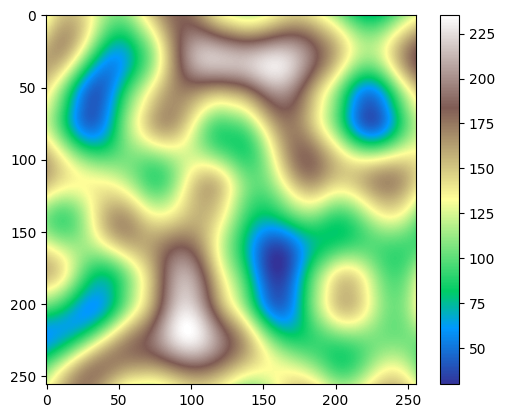

In [115]:
def scale(val, src, dst):
    """
    Scale the given value from the scale of src to the scale of dst.
    """
    return ((val - src[0]) / (src[1]-src[0])) * (dst[1]-dst[0]) + dst[0]

hmap_ = generate_perlin_noise_2d((256, 256), (4,4))
#hmap_ = scale(hmap_, (np.min(hmap_), np.max(hmap_)), (0, 1))
hmap_ = scale(hmap_, (-1, 1), (0, 256))
#hmap_ = imread('map.png')
#hmap_ = np.invert(hmap_)
#hmap_ = hmap_ / 255
hmap = np.copy(hmap_)
plt.imshow(hmap_, cmap='terrain', interpolation='lanczos')
plt.colorbar()

In [118]:
# Inspired by https://nickmcd.me/2020/04/10/simple-particle-based-hydraulic-erosion/
def vec2(x, y=None, dtype=float):
    if y is None:
        return np.array([x, x], dtype)
    return np.array([x, y], dtype)

def vec3(x, y=None, z=None, dtype=float):
    if y is None:
        return np.array([x, x, x], dtype)
    return np.array([x, y, z], dtype)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

class Particle:
    def __init__(self, pos):
        self.pos = pos
        self.speed = vec2(0)
        self.volume = 1
        self.sediment = 1

class World:
    def __init__(self, heightmap):
        self.heightmap = heightmap
        self.dt = 0.2
        self.min_volume = 0.01
        self.density = 1
        self.friction = 0.05
        self.deposition_rate = 0.1
        self.evaporation_rate = 0.001
        self.scale = 1

    def surface_normal(self, heightmap, i, j, scale):
        # Compute surface normal for x neighbors
        nx_pos = np.array([scale * (heightmap[i][j] - heightmap[i+1][j]), 1.0, 0.0])
        nx_neg = np.array([scale * (heightmap[i-1][j] - heightmap[i][j]), -1.0, 0.0])
        # Compute surface normal for y neighbors
        ny_pos = np.array([0.0, 1.0, scale * (heightmap[i][j] - heightmap[i][j+1])])
        ny_neg = np.array([0.0, -1.0, scale * (heightmap[i][j-1] - heightmap[i][j])])
        # Compute surface normal for diagonal neighbors
        n_diag1 = np.array([scale * (heightmap[i][j] - heightmap[i+1][j+1]) / np.sqrt(2), np.sqrt(2), scale * (heightmap[i][j] - heightmap[i+1][j+1]) / np.sqrt(2)])
        n_diag2 = np.array([scale * (heightmap[i][j] - heightmap[i+1][j-1]) / np.sqrt(2), np.sqrt(2), scale * (heightmap[i][j] - heightmap[i+1][j-1]) / np.sqrt(2)])
        n_diag3 = np.array([scale * (heightmap[i][j] - heightmap[i-1][j+1]) / np.sqrt(2), np.sqrt(2), scale * (heightmap[i][j] - heightmap[i-1][j+1]) / np.sqrt(2)])
        n_diag4 = np.array([scale * (heightmap[i][j] - heightmap[i-1][j-1]) / np.sqrt(2), np.sqrt(2), scale * (heightmap[i][j] - heightmap[i-1][j-1]) / np.sqrt(2)])
        # Compute total surface normal vector by summing all surface normal vectors with appropriate weights
        n = 0.15 * (np.linalg.norm(nx_pos) * nx_pos + np.linalg.norm(nx_neg) * nx_neg + np.linalg.norm(ny_pos) * ny_pos + np.linalg.norm(ny_neg) * ny_neg)
        n += 0.1 * (np.linalg.norm(n_diag1) * n_diag1 + np.linalg.norm(n_diag2) * n_diag2 + np.linalg.norm(n_diag3) * n_diag3 + np.linalg.norm(n_diag4) * n_diag4)
        # Normalize the total surface normal vector and return
        return n / np.linalg.norm(n)
    
    def gradient_at_point(self, array, i, j):
        # Check if i and j are within the bounds of the array
        if i < 0 or i >= array.shape[0] or j < 0 or j >= array.shape[1]:
            raise ValueError("Index out of bounds")

        # Calculate the gradient in the x direction using central difference method
        if j == 0:
            dx = array[i][1] - array[i][0]
        elif j == array.shape[1] - 1:
            dx = array[i][j] - array[i][j-1]
        else:
            dx = (array[i][j+1] - array[i][j-1])/2

        # Calculate the gradient in the y direction using central difference method
        if i == 0:
            dy = array[1][j] - array[0][j]
        elif i == array.shape[0] - 1:
            dy = array[i][j] - array[i-1][j]
        else:
            dy = (array[i+1][j] - array[i-1][j])/2

        # Return the gradient vector
        return np.array([dx, dy])

    def erode(self, cycles):
        for i in range(cycles):
            finished = int(100*(i/cycles))
            clear_output(wait=True)
            display(f'{finished}%')
                
            pos = np.random.uniform(self.heightmap.shape[0]-1, size=2)
            drop = Particle(pos)
            ipos = drop.pos.astype(int)
            #plt.scatter(ipos[1], ipos[0], c='r', s=2)
            

            while drop.volume > self.min_volume:
                ipos = drop.pos.astype(int)
                n = self.surface_normal(self.heightmap, ipos[0], ipos[1], 60) #vec3
                drop.speed += self.dt * vec2(n[0], n[1]) / (drop.volume * self.density)
                drop.pos   += self.dt * drop.speed
                drop.speed *= (1 - self.dt * self.friction)

                if np.any(drop.pos < 0) or np.any(drop.pos >= self.heightmap.shape[0]-1):
                    break
                
                max_sediment = drop.volume * np.sqrt(drop.speed.dot(drop.speed)) * (self.heightmap[ipos[0], ipos[1]] - self.heightmap[int(drop.pos[0]), int(drop.pos[1])])
                if max_sediment > 0:
                    max_sediment = 0
                sdiff = max_sediment - drop.sediment

                drop.sediment += self.dt * self.deposition_rate * sdiff
                self.heightmap[ipos[0], ipos[1]] += self.dt * drop.volume * self.deposition_rate * sdiff
                #self.heightmap[ipos[0], ipos[1]] = 0

                drop.volume *= (1 - self.dt*self.evaporation_rate)
            
            #plt.scatter(ipos[1], ipos[0], c='g')

In [119]:
hmap = np.copy(hmap_)
world = World(hmap)

world.erode(100)

'99%'

(256, 256)

In [17]:
with open('map.txt') as file:
    array2d = [[float(digit) for digit in line.split()] for line in file]

hmap = np.array(array2d)
assert(hmap.shape[0] == hmap.shape[1])

x, y = np.meshgrid(range(hmap.shape[0]), range(hmap.shape[1]))

#sh_0, sh_1 = z.shape
#x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=hmap, x=x, y=y, colorscale='earth', reversescale=True)])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

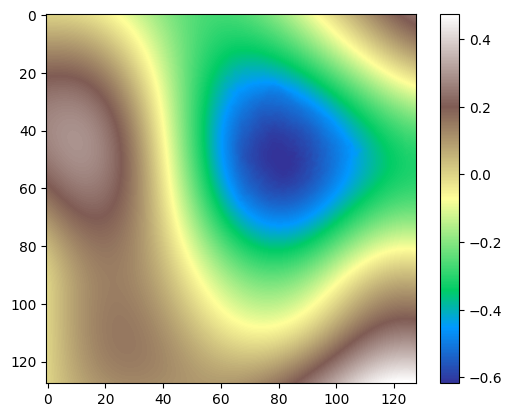

In [24]:
plt.imshow(hmap, cmap='terrain', interpolation='lanczos')
plt.colorbar()